## Final code 

In [1]:
# Import packages
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_dir = "/kaggle/input/bleed-detection/wcebleedGen/wcebleedGen"

BATCH_SIZE = 16
IMG_SIZE = (224, 224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset="training",
    batch_size=BATCH_SIZE,
    seed=42,
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=42,
)


Found 2618 files belonging to 2 classes.
Using 2095 files for training.
Found 2618 files belonging to 2 classes.
Using 523 files for validation.


In [3]:
# Print the class names to understand the mapping
print(train_data.class_names)

['bleeding', 'non-bleeding']


In [4]:
# Data Augmentation with Noise
data_augmentation = Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.GaussianNoise(0.1),  # You can adjust the noise level as needed
], name ="data_augmentation")


base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2L(include_top=False, weights='imagenet')
base_model.trainable = True

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
augmented_inputs = data_augmentation(inputs)
x = base_model(augmented_inputs, training=True)
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
outputs = layers.Dense(2, activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)




473176280/473176280 [==============================] - 2s 0us/step


In [5]:
model.summary()

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              metrics=["accuracy"])



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetv2-l (Functiona  (None, None, None, 1280)  117746848
 l)                                                              
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 2)                 2562      
                                                             

In [6]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "best_bleed_model.h5",
    save_best_only=True,
    save_weights_only=True,
    monitor="val_loss",
    verbose=1
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=4,
    verbose=1,
    restore_best_weights=True
)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    verbose=1
)


callbacks = [checkpoint_callback, early_stopping_callback, reduce_lr_callback]



In [7]:
hist = model.fit(train_data,
                 epochs=15,
                 validation_data=val_data,
                 batch_size=BATCH_SIZE,
                 callbacks = callbacks )

Epoch 1/15


2023-10-04 13:13:54.878900: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetv2-l/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


131/131 [==============================] - ETA: 0s - loss: 0.1647 - accuracy: 0.9317

2023-10-04 13:17:06.525790: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetv2-l/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer



Epoch 1: val_loss improved from inf to 0.15049, saving model to best_bleed_model.h5
131/131 [==============================] - 280s 606ms/step - loss: 0.1647 - accuracy: 0.9317 - val_loss: 0.1505 - val_accuracy: 0.9426 - lr: 1.0000e-04
Epoch 2/15
131/131 [==============================] - ETA: 0s - loss: 0.0593 - accuracy: 0.9800
Epoch 2: val_loss improved from 0.15049 to 0.04374, saving model to best_bleed_model.h5
131/131 [==============================] - 71s 541ms/step - loss: 0.0593 - accuracy: 0.9800 - val_loss: 0.0437 - val_accuracy: 0.9866 - lr: 1.0000e-04
Epoch 3/15
131/131 [==============================] - ETA: 0s - loss: 0.0748 - accuracy: 0.9771
Epoch 3: val_loss did not improve from 0.04374
131/131 [==============================] - 68s 518ms/step - loss: 0.0748 - accuracy: 0.9771 - val_loss: 0.0620 - val_accuracy: 0.9790 - lr: 1.0000e-04
Epoch 4/15
131/131 [==============================] - ETA: 0s - loss: 0.0302 - accuracy: 0.9876
Epoch 4: val_loss improved from 0.0437

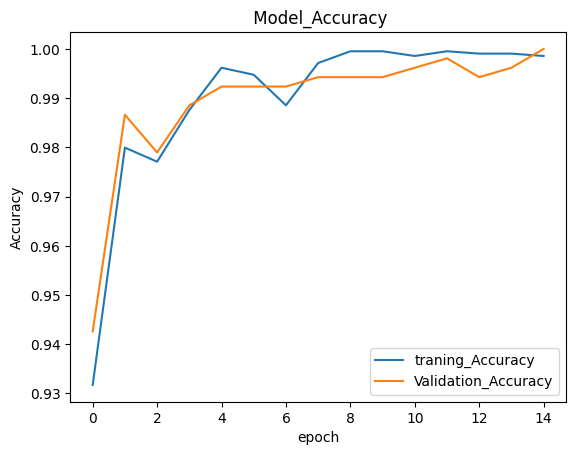

In [18]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title(" Model_Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['traning_Accuracy', 'Validation_Accuracy'])
plt.show()

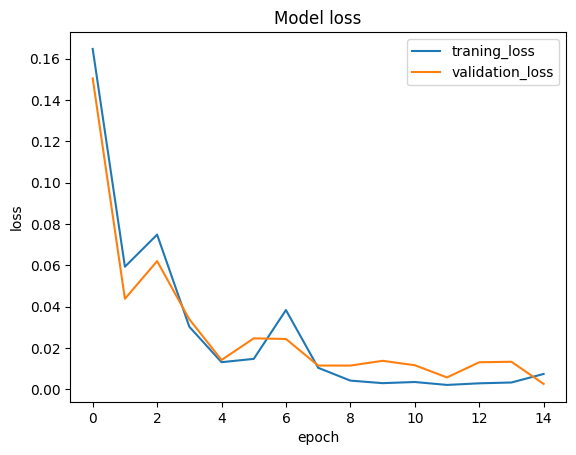

In [20]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['traning_loss', 'validation_loss'])
plt.show()

## CAM & Accuracy report with random images from val_data

In [8]:
def find_last_conv_layer(model):
    for layer in reversed(model.get_layer('efficientnetv2-l').layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer
    return None

def generate_cam(model, image, class_index):
    last_conv_layer = find_last_conv_layer(model)

    if last_conv_layer is None:
        raise ValueError("No convolutional layers found in the 'efficientnetv2-l' part of the model.")


    submodel = Model(inputs=model.get_layer('efficientnetv2-l').input, outputs=last_conv_layer.output)

    preprocessed_image = tf.keras.applications.efficientnet_v2.preprocess_input(image)
    preprocessed_image = tf.expand_dims(preprocessed_image, axis=0)

    # Computing feature map from the submodel
    feature_maps = submodel(preprocessed_image)

    class_weights = model.get_layer('output_layer').get_weights()[0]


    cam = np.dot(feature_maps.numpy()[0, ..., :], class_weights[:, class_index])
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
    cam = cv2.resize(cam, (224, 224))  # Resize to match the image size

    return cam




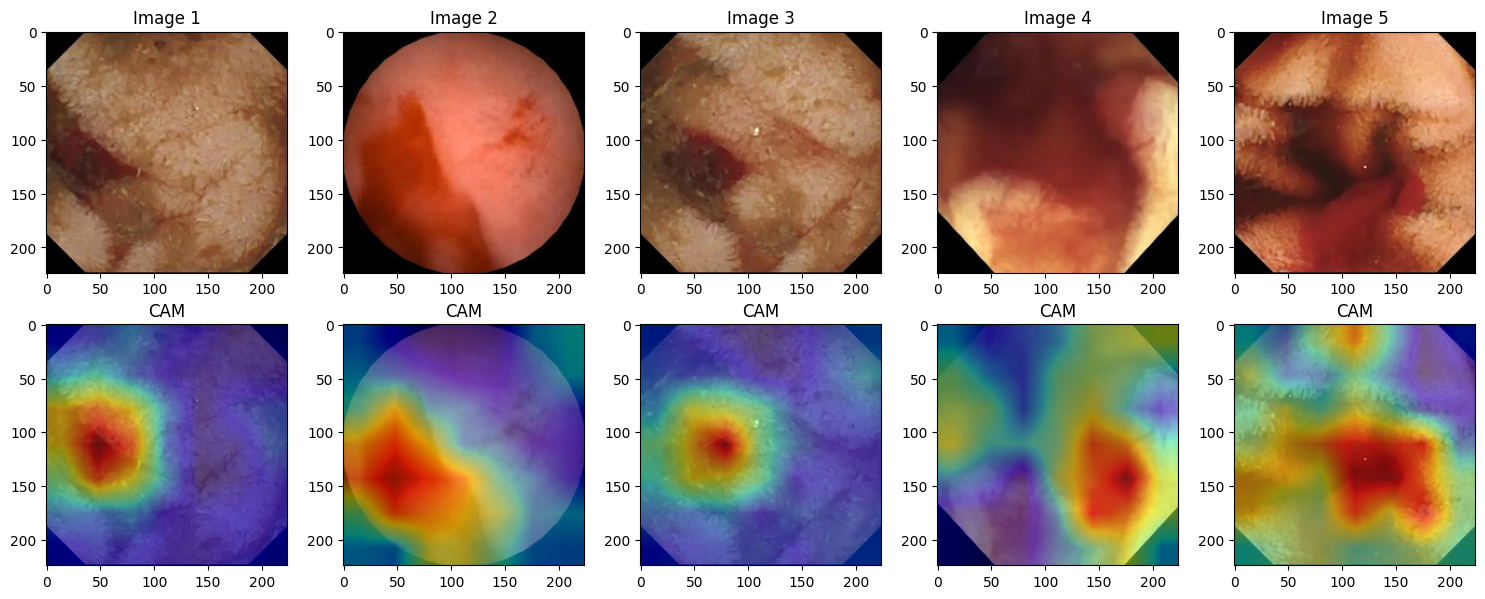

In [9]:
import random
random.seed(42)
val_data_iterator = iter(val_data)
bleeding_class_index = 0


bleeding_images = []


while len(bleeding_images) < 5:
    
    batch_images, batch_labels = next(val_data_iterator)
    
    
    for i in range(len(batch_labels)):
        if batch_labels[i][bleeding_class_index] == 1:
            bleeding_images.append(batch_images[i])
            if len(bleeding_images) == 5:
                break


class_index = 0


plt.figure(figsize=(15, 6))
for i, image in enumerate(bleeding_images):
    cam_image = generate_cam(model, image, class_index)

    
    plt.subplot(2, 5, i + 1)
    plt.imshow(image / 255.0)  
    plt.title(f"Image {i + 1}")

    
    plt.subplot(2, 5, i + 6)
    plt.imshow(image / 255.0)  
    plt.imshow(cam_image, cmap="jet", alpha=0.5)
    plt.title("CAM")

plt.tight_layout()
plt.show()


2023-10-04 13:36:42.940034: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetv2-l/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 7s 7s/step


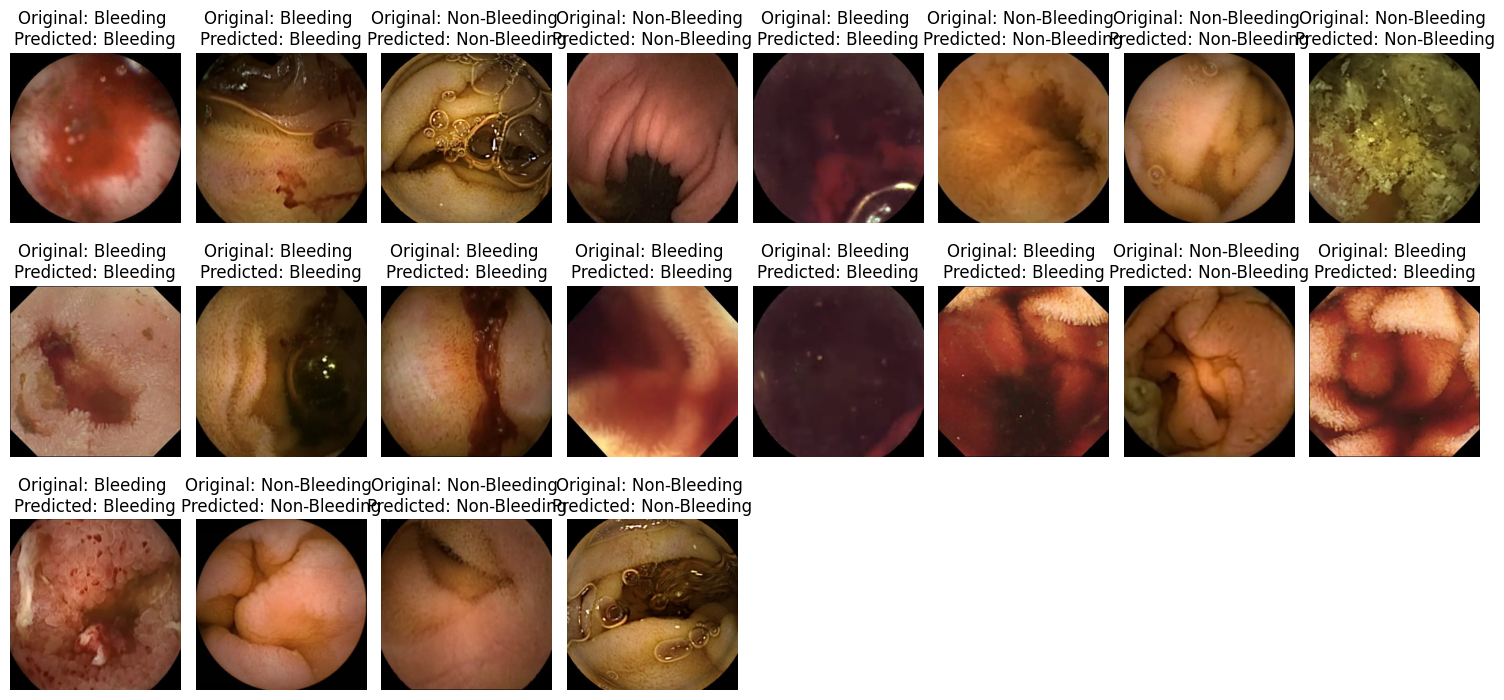

In [10]:
random.seed(42)

val_data_iterator = iter(val_data)
num_images_to_plot = 20
selected_images = []
true_labels = []


for _ in range(num_images_to_plot):
    
    batch_images, batch_labels = next(val_data_iterator)
   
    random_index = random.randint(0, len(batch_images) - 1)
    selected_image = batch_images[random_index]
    selected_label = batch_labels[random_index]
    
    selected_images.append(selected_image)
    true_labels.append(selected_label)

selected_images = np.array(selected_images)

predicted_labels = model.predict(selected_images)

predicted_classes = np.argmax(predicted_labels, axis=1)

class_names = ['Bleeding', 'Non-Bleeding']


plt.figure(figsize=(15, 12))
for i in range(num_images_to_plot):
    plt.subplot(5, 8, i + 1)
    plt.imshow(selected_images[i] / 255.0) 
    plt.title(f"Original: {class_names[np.argmax(true_labels[i])]} \nPredicted: {class_names[predicted_classes[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [16]:
model = tf.keras.models.load_model("/kaggle/working/bleed.h5")

In [17]:
from sklearn.metrics import classification_report

y_true = []
y_pred = []

for images, labels in val_data:
    predictions = model.predict(images, verbose=0)
    y_true.extend(tf.argmax(labels, axis=1))
    y_pred.extend(tf.argmax(predictions, axis=1))

classification_metrics = classification_report(y_true, y_pred, target_names=["bleeding", "non-bleeding"])
print(classification_metrics)


2023-10-04 13:41:46.147778: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetv2-l/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


              precision    recall  f1-score   support

    bleeding       1.00      1.00      1.00       258
non-bleeding       1.00      1.00      1.00       265

    accuracy                           1.00       523
   macro avg       1.00      1.00      1.00       523
weighted avg       1.00      1.00      1.00       523



In [13]:
image_names = []
predicted_labels = []

folder_path = "/kaggle/input/wce-test/Auto-WCEBleedGen Challenge Test Dataset/Test Dataset 2"
# Create a function to load and preprocess an image
def preprocess_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.cast(img, tf.float32) / 255.0  
    return img

# Get a list of image file names in the folder and sort them
image_file_names = os.listdir(folder_path)
image_file_names.sort()

# Iterate over the images in the folder
for image_name in image_file_names:
    # Remove the file extension (.png) and save only the image name
    image_name_without_extension = os.path.splitext(image_name)[0]
    
    image_path = os.path.join(folder_path, image_name)
    
    # Preprocess the image
    image = preprocess_image(image_path)
    image = tf.expand_dims(image, axis=0)  
    predictions = model.predict(image, verbose=0)
    
    predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
    predicted_class = "Bleeding" if predicted_class_index == 0 else "Non-Bleeding"
    
    image_names.append(image_name_without_extension)
    predicted_labels.append(predicted_class)

result_df = pd.DataFrame({"Image Name": image_names, "Predicted Label": predicted_labels})

result_df.to_csv("submission2.csv", index=False)


In [14]:
model.save('bleed.h5')